# Stochastic Gradient Descent (SGD)

## Load Dataset from sklearn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


C:\Users\kyeul\anaconda3\envs\nlp\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


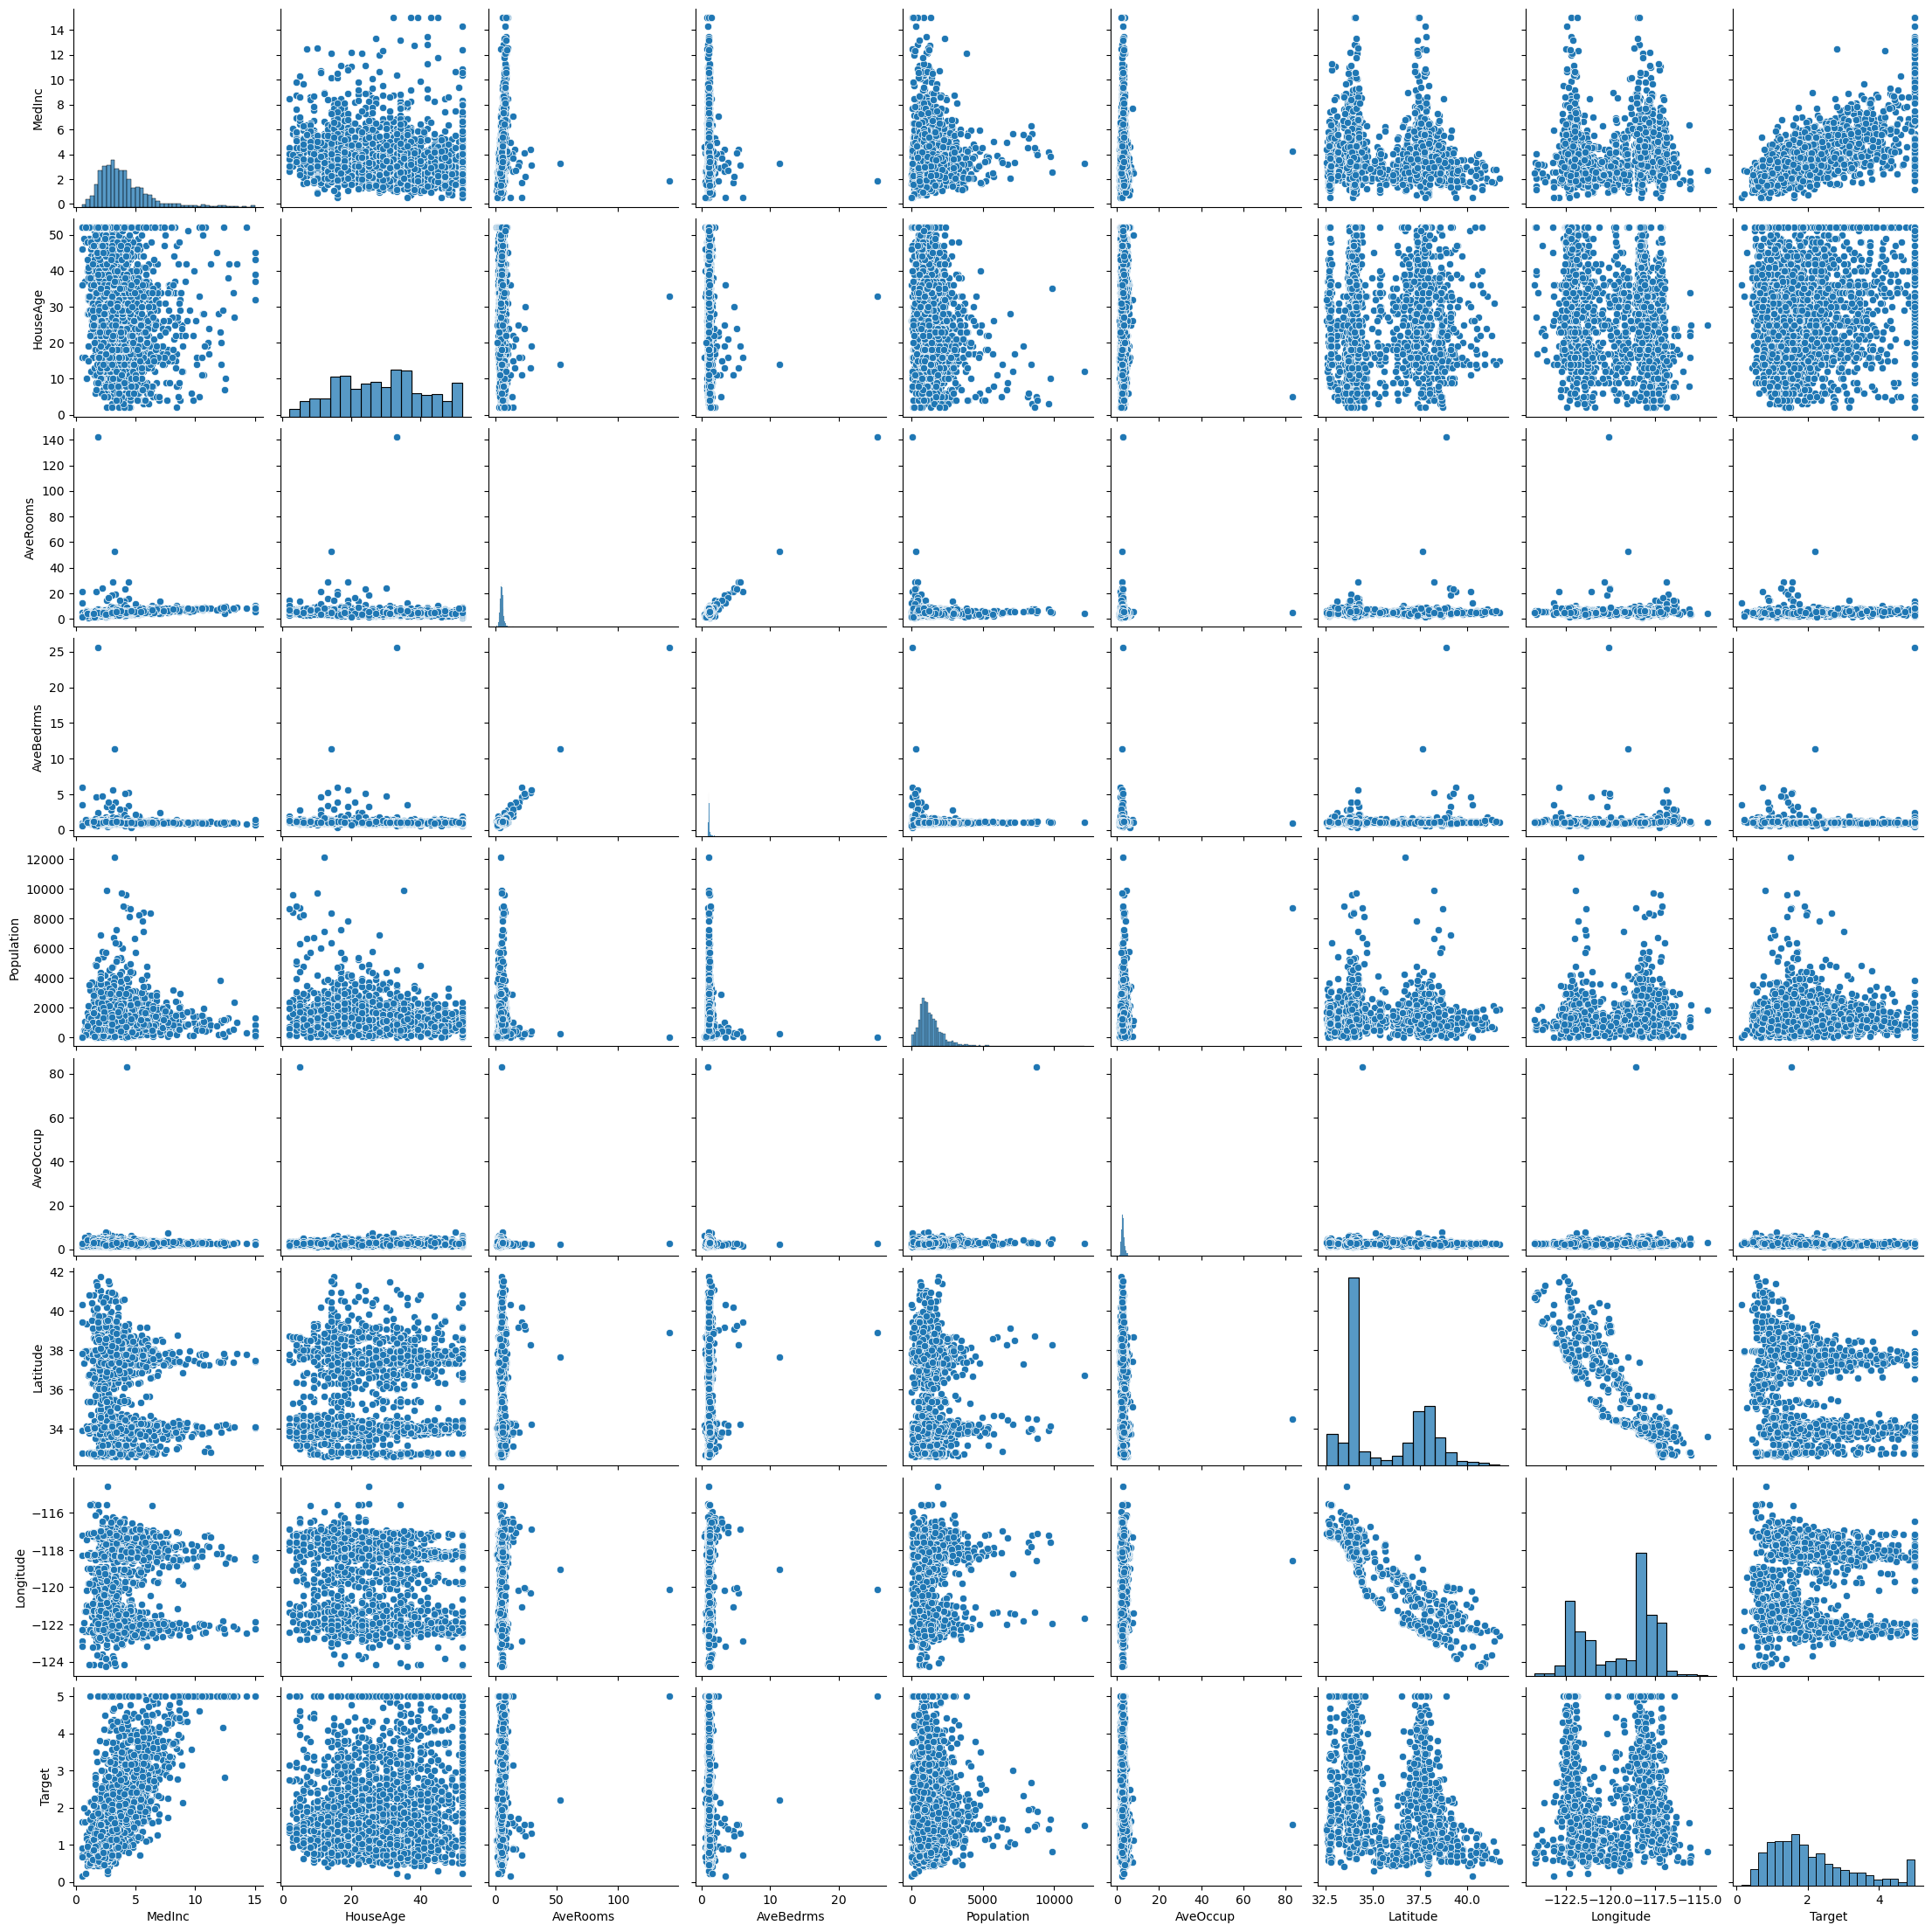

In [4]:
sns.pairplot(df.sample(2000))
plt.show()

In [6]:
scaler = StandardScaler()
scaler.fit(df.values[:, :-1]) # 정규분포를 구하고
df.values[:, :-1] = scaler.transform(df.values[:, :-1]) #구한 정규분포값 적용

C:\Users\kyeul\anaconda3\envs\nlp\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


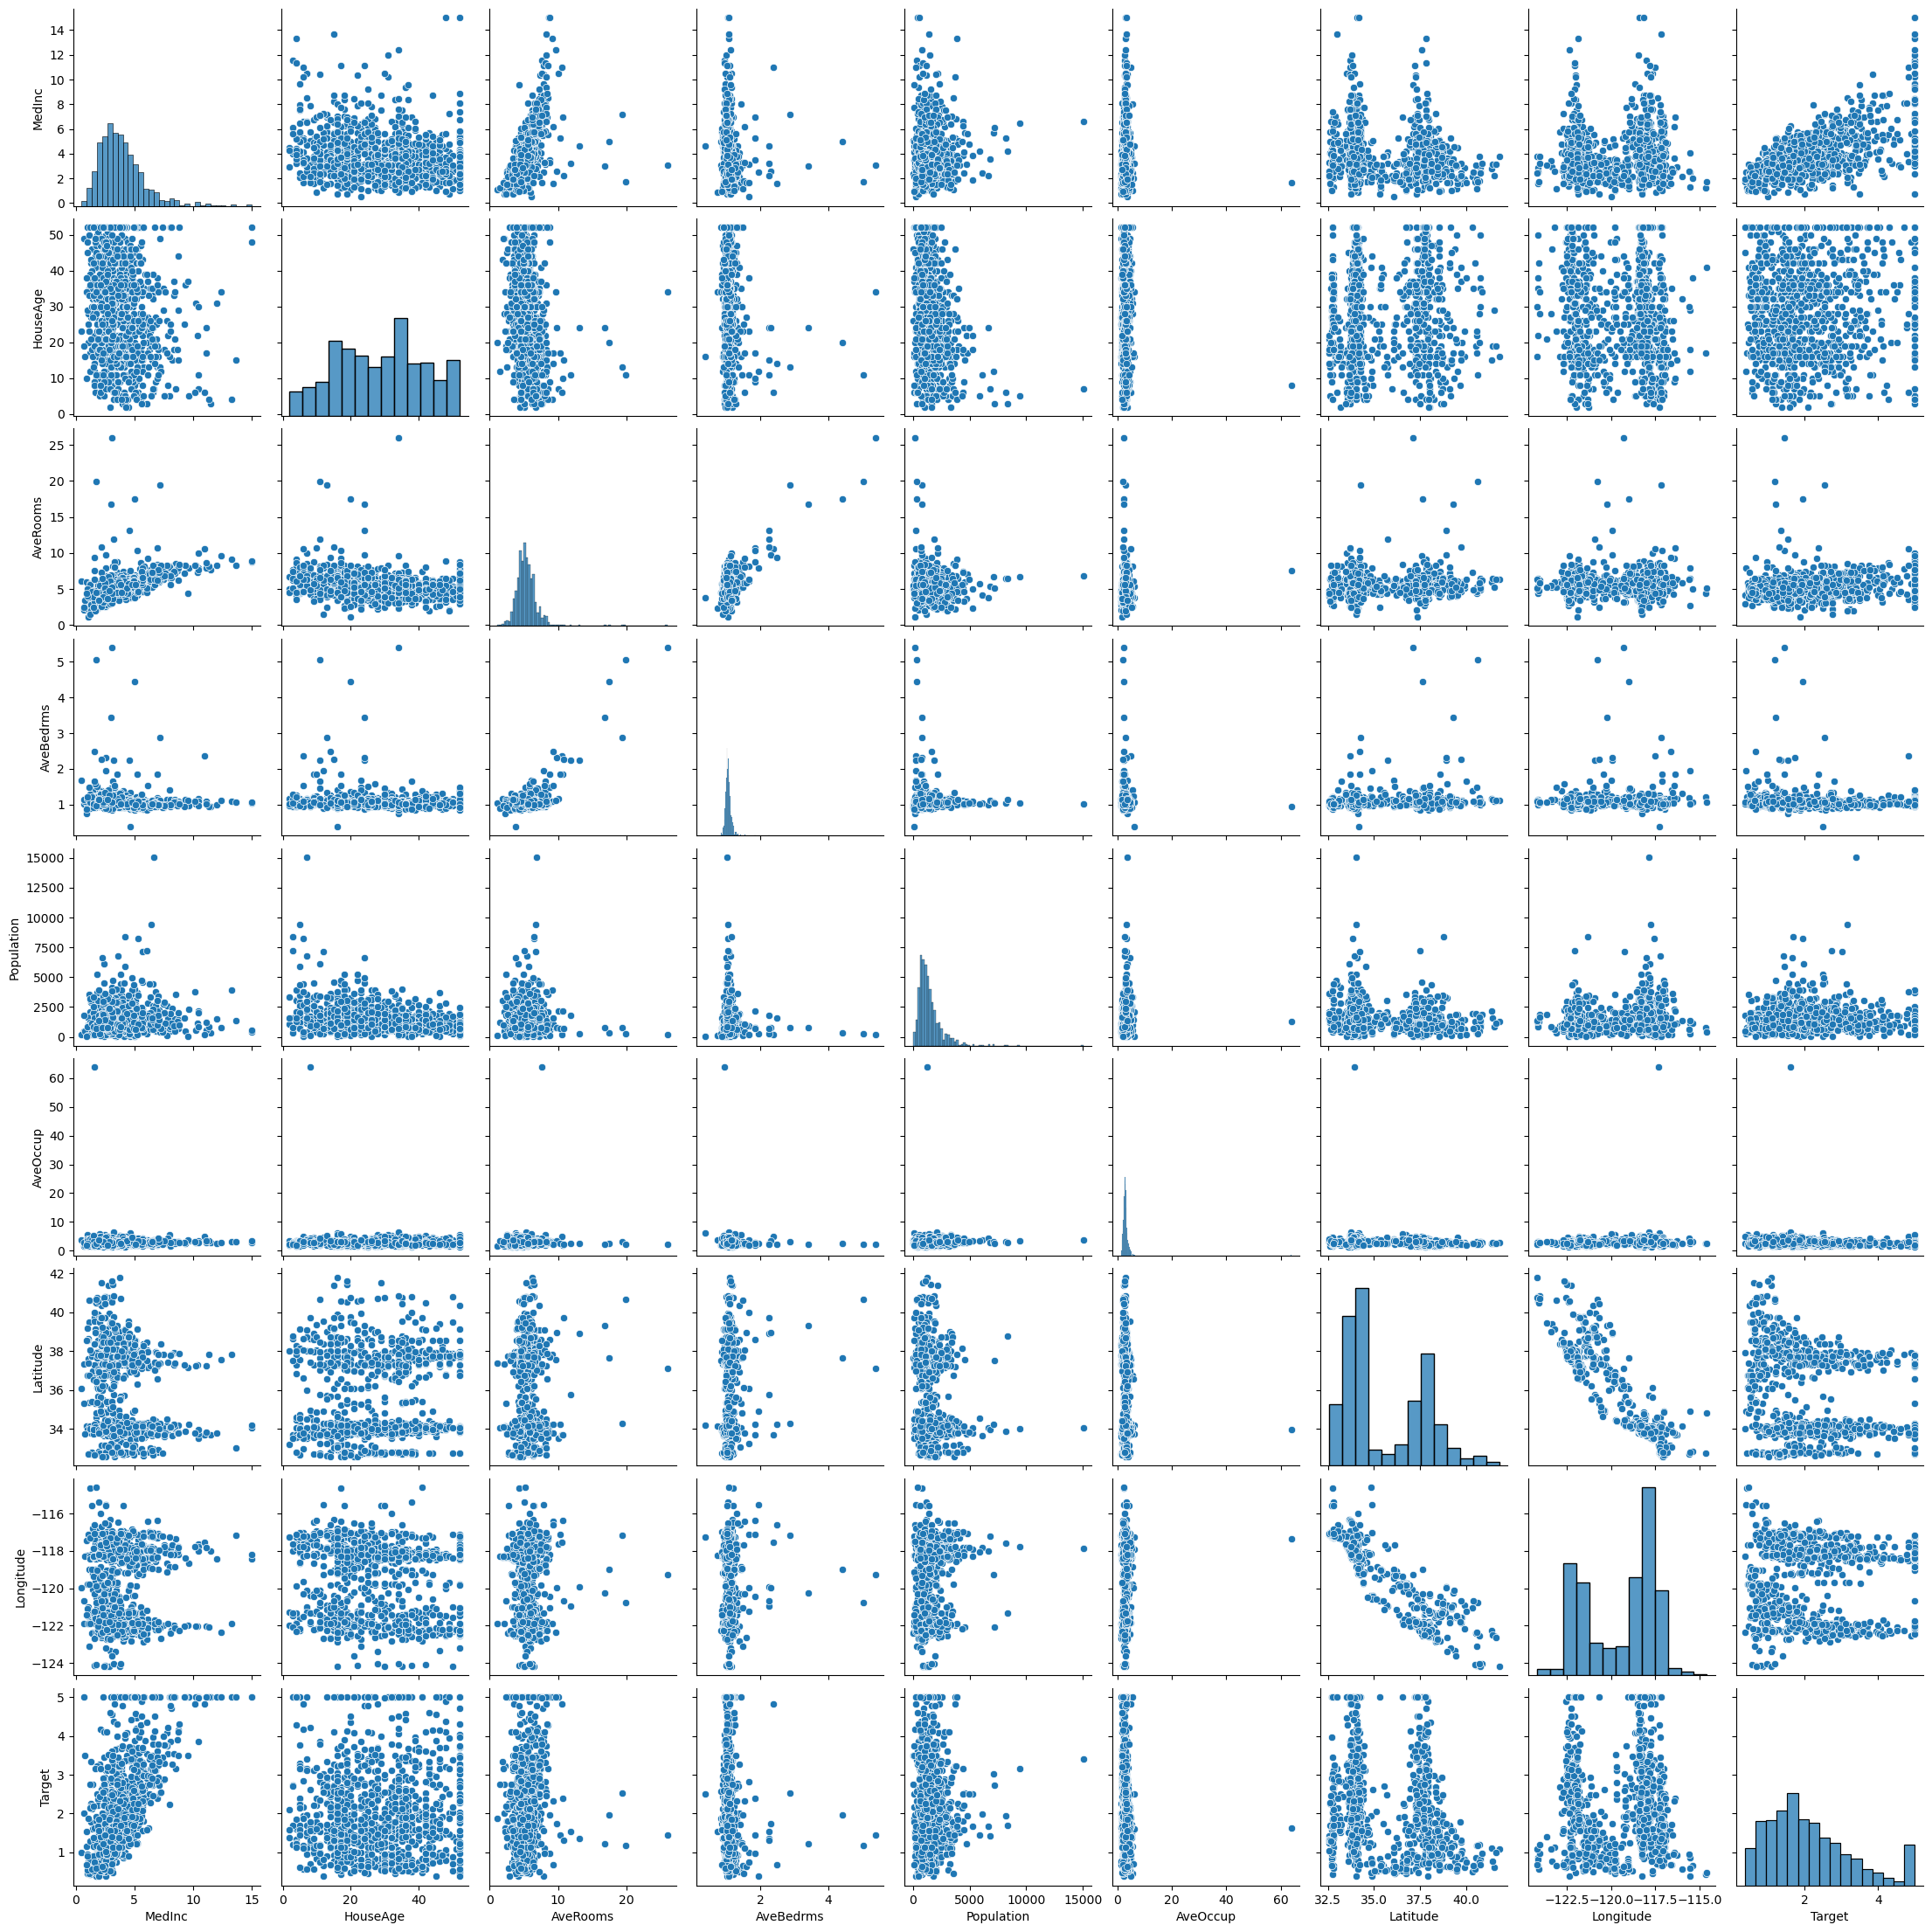

In [7]:
sns.pairplot(df.sample(1000))
plt.show()

## Train Model with Pytorch

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [10]:
x = data[:, :-1].cuda()
y = data[:, -1:].cuda()

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [51]:
# figures
n_epochs = 5000
batch_size = 4096
print_interval = 50
learning_rate = 1e-2

## Build Models

In [47]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        self.Linear = nn.Linear(self.input_dim, 6).cuda()
        self.Linear2 = nn.Linear(6, 5).cuda()
        self.Linear3 = nn.Linear(5, 4).cuda()
        self.Linear4 = nn.Linear(4, 3).cuda()
        self.Linear5 = nn.Linear(3, self.output_dim).cuda()
        self.act = nn.LeakyReLU()
        
    def forward(self, x):
        h = self.act(self.Linear(x))
        h = self.act(self.Linear2(h))
        h = self.act(self.Linear3(h))
        h = self.act(self.Linear4(h))
        y = self.Linear5(h)
        
        return y

In [52]:
model = MyModel(x.size(-1), y.size(-1))
model

MyModel(
  (Linear): Linear(in_features=8, out_features=6, bias=True)
  (Linear2): Linear(in_features=6, out_features=5, bias=True)
  (Linear3): Linear(in_features=5, out_features=4, bias=True)
  (Linear4): Linear(in_features=4, out_features=3, bias=True)
  (Linear5): Linear(in_features=3, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [53]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [54]:
# |x| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs): # epoch을 위한 반복문
    # Shuffle the index to feed-forward
    indices = torch.randperm(x.size(0)).cuda()
    x_ = torch.index_select(x, dim=0, index=indices) # sampling with batch_size
    y_ = torch.index_select(y, dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0) # |x_i| = (batch_size, input_dim)
    y_ = y_.split(batch_size, dim=0) 
    
    y_hat = []
    total_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_{i}|
        # |y_i| = |y_{i}|
        
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i) 
        
        optimizer.zero_grad() # gradient 초기화
        loss.backward() # backpropagation
        
        optimizer.step() # update parameters
        
        total_loss += float(loss) # This is very important to prevent memory leak.
        y_hat += [y_hat_i]
    
    total_loss = total_loss / len(x_)
    if (i + 1) % print_interval == 0:
        print(f"Epoch {i+1}: loss={total_loss:.5f}")
        

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)
        

Epoch 50: loss=1.34935
Epoch 100: loss=1.32679
Epoch 150: loss=1.32312
Epoch 200: loss=1.29831
Epoch 250: loss=1.31013
Epoch 300: loss=1.28472
Epoch 350: loss=1.37527
Epoch 400: loss=1.29104
Epoch 450: loss=1.33947
Epoch 500: loss=1.34983
Epoch 550: loss=1.34195
Epoch 600: loss=1.32987
Epoch 650: loss=1.31830
Epoch 700: loss=1.31366
Epoch 750: loss=1.34189
Epoch 800: loss=1.31725
Epoch 850: loss=1.30894
Epoch 900: loss=1.34981
Epoch 950: loss=1.33543
Epoch 1000: loss=1.32756
Epoch 1050: loss=1.37903
Epoch 1100: loss=1.29859
Epoch 1150: loss=1.33837
Epoch 1200: loss=1.26874
Epoch 1250: loss=1.30482
Epoch 1300: loss=1.31861
Epoch 1350: loss=1.34671
Epoch 1400: loss=1.32270
Epoch 1450: loss=1.29019
Epoch 1500: loss=1.31248
Epoch 1550: loss=1.31733
Epoch 1600: loss=1.30315
Epoch 1650: loss=1.37571
Epoch 1700: loss=1.34454
Epoch 1750: loss=1.32811
Epoch 1800: loss=1.34574
Epoch 1850: loss=1.31740
Epoch 1900: loss=1.35021
Epoch 1950: loss=1.32526
Epoch 2000: loss=1.32022
Epoch 2050: loss=1.3

C:\Users\kyeul\anaconda3\envs\nlp\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\kyeul\anaconda3\envs\nlp\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


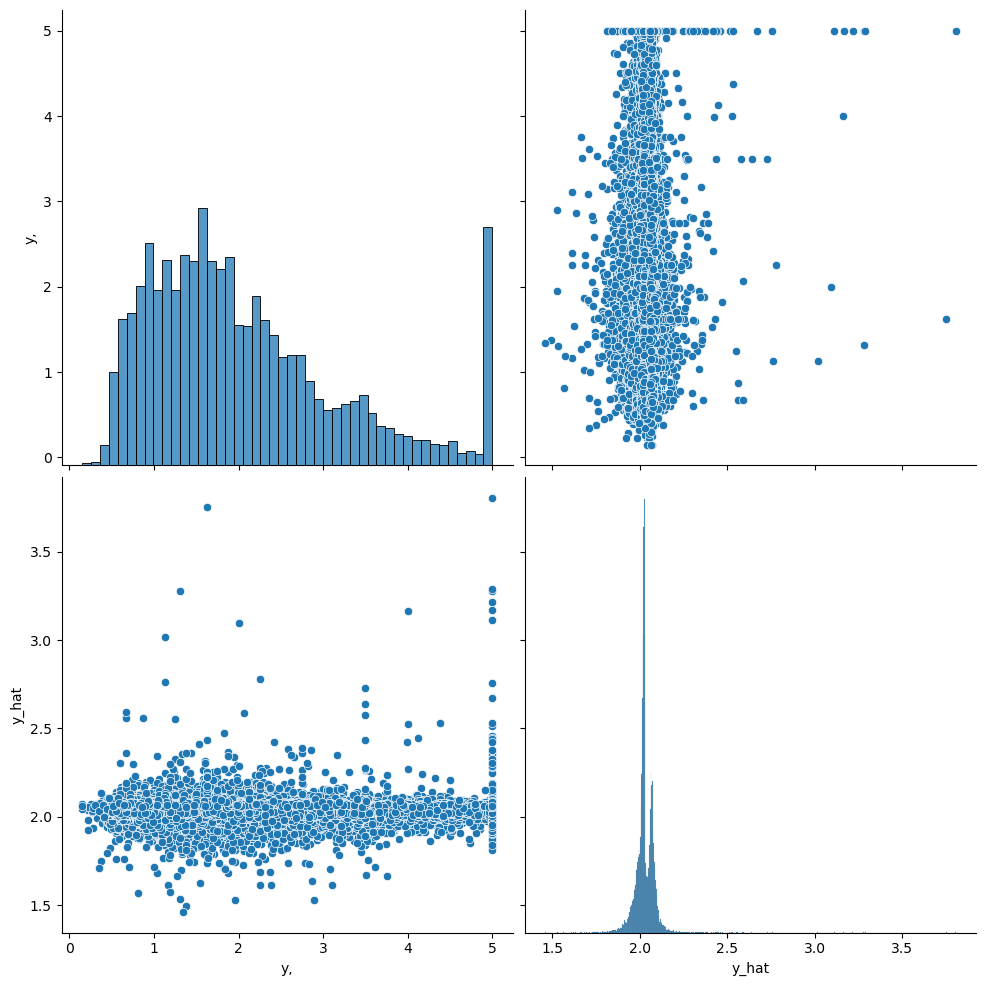

In [59]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().cpu().numpy(), columns=["y,", "y_hat"])
sns.pairplot(df, size=5)
plt.show()